# 019 - Sklearn DuckDB SQL Classification (Sklearn Visualizations)

This notebook mirrors the **DuckDB SQL preprocessing** used in the SvelteKit Batch ML classification flow,
but excludes YellowBrick so we can focus on native sklearn visualization APIs.

In [3]:
import duckdb
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
MINIO_HOST = "localhost"
MINIO_PORT = "9000"
MINIO_ENDPOINT = f"{MINIO_HOST}:{MINIO_PORT}"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin123"
PROJECT_NAME = "Transaction Fraud Detection"

In [5]:
DELTA_PATHS = {
    "Transaction Fraud Detection": "s3://lakehouse/delta/transaction_fraud_detection",
    "Estimated Time of Arrival": "s3://lakehouse/delta/estimated_time_of_arrival",
    "E-Commerce Customer Interactions": "s3://lakehouse/delta/e_commerce_customer_interactions",
}

delta_path = DELTA_PATHS.get(PROJECT_NAME)

In [6]:
# Disable AWS EC2 metadata service lookup (prevents 169.254.169.254 errors)
os.environ["AWS_EC2_METADATA_DISABLED"] = "true"

# Create connection (in-memory database)
conn = duckdb.connect()

# Install and load required extensions
conn.execute("INSTALL delta; LOAD delta;")
conn.execute("INSTALL httpfs; LOAD httpfs;")

# Create a secret for S3/MinIO credentials
conn.execute(f"""
    CREATE SECRET minio_secret (
        TYPE S3,
        KEY_ID '{MINIO_ACCESS_KEY}',
        SECRET '{MINIO_SECRET_KEY}',
        REGION 'us-east-1',
        ENDPOINT '{MINIO_ENDPOINT}',
        URL_STYLE 'path',
        USE_SSL false
    );
""")
print("DuckDB extensions loaded and S3 secret configured")

DuckDB extensions loaded and S3 secret configured


## Feature Definitions

Define features upfront for CatBoost's native categorical handling.

In [7]:
# Feature definitions for Transaction Fraud Detection
TFD_NUMERICAL_FEATURES = [
    "amount",
    "account_age_days",
    "cvv_provided",
    "billing_address_match",
]

TFD_CATEGORICAL_FEATURES = [
    "currency",
    "merchant_id",
    "payment_method",
    "product_category",
    "transaction_type",
    "browser",
    "os",
    "year",
    "month",
    "day",
    "hour",
    "minute",
    "second",
]

TFD_ALL_FEATURES = TFD_NUMERICAL_FEATURES + TFD_CATEGORICAL_FEATURES

# Categorical feature indices for CatBoost (position in feature list)
TFD_CAT_FEATURE_INDICES = list(range(
    len(TFD_NUMERICAL_FEATURES),
    len(TFD_ALL_FEATURES)
))

print(f"Numerical features: {len(TFD_NUMERICAL_FEATURES)}")
print(f"Categorical features: {len(TFD_CATEGORICAL_FEATURES)}")
print(f"Categorical indices: {TFD_CAT_FEATURE_INDICES}")

Numerical features: 4
Categorical features: 13
Categorical indices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## DuckDB SQL Preprocessing

All categorical features are label-encoded in SQL using `DENSE_RANK() - 1`.

In [8]:
def load_data_duckdb_sql(
    delta_path: str,
    sample_frac: float | None = None,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Load and preprocess data using pure DuckDB SQL.
    
    All categorical features are label-encoded using DENSE_RANK() - 1.
    This produces numeric data compatible with sklearn visualization APIs.
    
    Args:
        delta_path: Path to Delta Lake table
        sample_frac: Optional fraction of data to sample (0.0-1.0)
        max_rows: Optional maximum number of rows to load
    
    Returns:
        DataFrame with preprocessed features (all numeric) and target
    """
    # Single query: All features numeric, categoricals label-encoded
    query = f"""
    SELECT
        -- Numerical features (unchanged)
        amount,
        account_age_days,
        CAST(cvv_provided AS INTEGER) AS cvv_provided,
        CAST(billing_address_match AS INTEGER) AS billing_address_match,

        -- Categorical features: Label encoded with DENSE_RANK() - 1
        -- This produces 0-indexed integers compatible with sklearn tools
        DENSE_RANK() OVER (ORDER BY currency) - 1 AS currency,
        DENSE_RANK() OVER (ORDER BY merchant_id) - 1 AS merchant_id,
        DENSE_RANK() OVER (ORDER BY payment_method) - 1 AS payment_method,
        DENSE_RANK() OVER (ORDER BY product_category) - 1 AS product_category,
        DENSE_RANK() OVER (ORDER BY transaction_type) - 1 AS transaction_type,
        
        -- JSON extraction + Label encoded
        DENSE_RANK() OVER (ORDER BY json_extract_string(device_info, '$.browser')) - 1 AS browser,
        DENSE_RANK() OVER (ORDER BY json_extract_string(device_info, '$.os')) - 1 AS os,

        -- Timestamp components (already integers)
        CAST(date_part('year', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS year,
        CAST(date_part('month', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS month,
        CAST(date_part('day', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS day,
        CAST(date_part('hour', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS hour,
        CAST(date_part('minute', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS minute,
        CAST(date_part('second', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS second,

        -- Target
        is_fraud

    FROM delta_scan('{delta_path}')
    """
    
    print(f"Loading data with DuckDB SQL (all features numeric)...")

    # Add sampling clause
    if sample_frac is not None and 0 < sample_frac < 1:
        query += f" USING SAMPLE {sample_frac * 100}%"
        print(f"  Sampling: {sample_frac * 100}%")

    # Add limit clause
    if max_rows is not None:
        query += f" LIMIT {max_rows}"
        print(f"  Max rows: {max_rows}")

    df = conn.execute(query).df()
    print(f"  Loaded {len(df):,} rows with {len(df.columns)} columns")
    print(f"  All features numeric: {df.select_dtypes(include=['number']).shape[1]}/{len(df.columns)} columns")
    
    return df

In [9]:
df = load_data_duckdb_sql(delta_path, max_rows=10000)

Loading data with DuckDB SQL (all features numeric)...
  Max rows: 10000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 10,000 rows with 18 columns
  All features numeric: 18/18 columns


In [10]:
def process_batch_data_duckdb(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
):
    """
    Process batch data for model training.
    
    Data is already all-numeric from load_data_duckdb_sql().
    
    Args:
        df: DataFrame from load_data_duckdb_sql() (all numeric)
        test_size: Fraction for test set
        random_state: Random seed
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    # Split features and target
    y = df["is_fraud"]
    X = df.drop("is_fraud", axis=1)
    
    print(f"Features: {len(X.columns)} total ({len(TFD_NUMERICAL_FEATURES)} numeric, {len(TFD_CATEGORICAL_FEATURES)} label-encoded)")
    print(f"All features are numeric - compatible with sklearn tools")
    
    # Stratified train/test split (keeps class balance)
    print(f"Splitting data: {1-test_size:.0%} train, {test_size:.0%} test (stratified)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )
    
    print(f"  Training set: {len(X_train):,} samples")
    print(f"  Test set: {len(X_test):,} samples")
    
    # Calculate class balance
    fraud_rate = y_train.sum() / len(y_train) * 100
    print(f"  Fraud rate in training set: {fraud_rate:.2f}%")
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = process_batch_data_duckdb(df)

Features: 17 total (4 numeric, 13 label-encoded)
All features are numeric - compatible with sklearn tools
Splitting data: 80% train, 20% test (stratified)...
  Training set: 8,000 samples
  Test set: 2,000 samples
  Fraud rate in training set: 0.97%


## Sklearn Visualization API (Classification)

This section mirrors the YellowBrick visualizer configuration pattern from notebook 010,
but uses sklearn Display classes and tuned kwargs for classification.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import DecisionBoundaryDisplay, PartialDependenceDisplay
from sklearn.metrics import ConfusionMatrixDisplay, DetCurveDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import LearningCurveDisplay, ValidationCurveDisplay

In [27]:
CATBOOST_PARAMS = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'auto_class_weights': 'Balanced',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'l2_leaf_reg': 3,
    'boosting_type': 'Plain',
    'task_type': 'CPU',
    'thread_count': -1,
    'random_seed': 42,
    'verbose': 100,
    'allow_writing_files': False,
}

catboost_model = CatBoostClassifier(**CATBOOST_PARAMS)

catboost_model.fit(
    X_train,
    y_train,
    cat_features=TFD_CAT_FEATURE_INDICES,
)

print('CatBoostClassifier fitted for scikit-plot visualizations.')


0:	total: 36.6ms	remaining: 36.6s
100:	total: 3.08s	remaining: 27.5s
200:	total: 6.92s	remaining: 27.5s
300:	total: 10.6s	remaining: 24.6s
400:	total: 15s	remaining: 22.4s
500:	total: 18.2s	remaining: 18.1s
600:	total: 21.4s	remaining: 14.2s
700:	total: 24.6s	remaining: 10.5s
800:	total: 27.6s	remaining: 6.87s
900:	total: 30.6s	remaining: 3.36s
999:	total: 34.4s	remaining: 0us
CatBoostClassifier fitted for scikit-plot visualizations.


In [28]:
class CatBoostClassifierSklearnWrapperCV(ClassifierMixin, BaseEstimator):
    """CatBoost wrapper that supports CV-based sklearn Display APIs."""
    _estimator_type = 'classifier'

    def __init__(self, cat_features=None, **params):
        self.cat_features = cat_features
        # Store params as attributes so sklearn can set/get them
        for key, value in params.items():
            setattr(self, key, value)
        self._params = params

    def get_params(self, deep=True):
        params = {**self._params, 'cat_features': self.cat_features}
        return params

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        # keep cat_features consistent
        if 'cat_features' in params:
            self.cat_features = params['cat_features']
        self._params.update({k: v for k, v in params.items() if k != 'cat_features'})
        return self

    def fit(self, X, y):
        # Rebuild params from current attributes for sklearn CV
        params = {k: getattr(self, k) for k in self._params.keys()}
        self.model_ = CatBoostClassifier(**params)
        self.model_.fit(X, y, cat_features=self.cat_features)
        try:
            self.classes_ = np.array(self.model_.classes_)
        except Exception:
            self.classes_ = None
        self.n_features_in_ = X.shape[1]
        if hasattr(X, 'columns'):
            self.feature_names_in_ = np.array(list(X.columns))
        return self

    def predict(self, X):
        return self.model_.predict(X).flatten()

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

    def __sklearn_tags__(self):
        return super().__sklearn_tags__()


In [29]:
feature_names = list(X_train.columns)
categorical_features = [
    feature_names.index(name)
    for name in TFD_CATEGORICAL_FEATURES
    if name in feature_names
]
pos_label = 1

# CatBoost for sklearn visualizers
sklearn_estimator = CatBoostClassifierSklearnWrapper(
    catboost_model,
    feature_names=feature_names,
    n_features=X_train.shape[1],
)
print('Sklearn displays will use CatBoostClassifier.')

boundary_features = ['amount', 'account_age_days']
X_train_boundary = X_train[boundary_features]
X_test_boundary = X_test[boundary_features]
boundary_cat_feature_indices = [
    i for i, name in enumerate(boundary_features)
    if name in TFD_CATEGORICAL_FEATURES
]

boundary_estimator = CatBoostClassifier(**CATBOOST_PARAMS)
boundary_estimator.fit(
    X_train_boundary,
    y_train,
    cat_features=boundary_cat_feature_indices,
)
print('Boundary CatBoost fitted for 2D decision surface.')
boundary_wrapper = CatBoostClassifierSklearnWrapper(
    boundary_estimator,
    feature_names=boundary_features,
    n_features=len(boundary_features),
)

cv_catboost_params = {**CATBOOST_PARAMS, 'verbose': False}
validation_estimator = CatBoostClassifierSklearnWrapperCV(
    cat_features=TFD_CAT_FEATURE_INDICES,
    **cv_catboost_params,
)


Sklearn displays will use CatBoostClassifier.
0:	total: 6.29ms	remaining: 6.28s
100:	total: 599ms	remaining: 5.33s
200:	total: 1.15s	remaining: 4.55s
300:	total: 1.71s	remaining: 3.98s
400:	total: 2.26s	remaining: 3.37s
500:	total: 2.88s	remaining: 2.86s
600:	total: 3.47s	remaining: 2.31s
700:	total: 3.92s	remaining: 1.67s
800:	total: 4.4s	remaining: 1.09s
900:	total: 4.95s	remaining: 544ms
999:	total: 5.45s	remaining: 0us
Boundary CatBoost fitted for 2D decision surface.


In [30]:
SKLEARN_VIZ_PATH = 'models/transaction_fraud_detection/sklearn_visualizations'
os.makedirs(SKLEARN_VIZ_PATH, exist_ok=True)

def save_display(display, filename: str, show: bool = True) -> str:
    output_path = os.path.join(SKLEARN_VIZ_PATH, filename)
    if show:
        plt.show()
    display.figure_.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(display.figure_)
    return output_path

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

def save_figure(fig, filename: str, show: bool = True) -> str:
    output_path = os.path.join(SKLEARN_VIZ_PATH, filename)
    if show:
        plt.show()
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    return output_path

def plot_catboost_learning_curve(
    X,
    y,
    train_sizes,
    cv,
    scoring='roc_auc',
    title='Learning Curve (CatBoost)',
    ax=None,
    figsize=(7, 5),
    random_state=42,
):
    if isinstance(cv, int):
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    rng = np.random.RandomState(random_state)
    n_samples = len(X)
    sizes = []
    for s in train_sizes:
        if s <= 1.0:
            sizes.append(max(2, int(s * n_samples)))
        else:
            sizes.append(int(min(s, n_samples)))

    train_means = []
    train_stds = []
    val_means = []
    val_stds = []

    for size in sizes:
        train_scores = []
        val_scores = []
        for train_idx, val_idx in cv.split(X, y):
            if size < len(train_idx):
                sub_idx = rng.choice(train_idx, size=size, replace=False)
            else:
                sub_idx = train_idx

            X_train_sub = X.iloc[sub_idx] if hasattr(X, 'iloc') else X[sub_idx]
            y_train_sub = y.iloc[sub_idx] if hasattr(y, 'iloc') else y[sub_idx]
            X_val = X.iloc[val_idx] if hasattr(X, 'iloc') else X[val_idx]
            y_val = y.iloc[val_idx] if hasattr(y, 'iloc') else y[val_idx]

            model = CatBoostClassifier(**CATBOOST_PARAMS)
            model.fit(X_train_sub, y_train_sub, cat_features=TFD_CAT_FEATURE_INDICES)

            if scoring in ('roc_auc', 'roc_auc_score'):
                train_pred = model.predict_proba(X_train_sub)[:, 1]
                val_pred = model.predict_proba(X_val)[:, 1]
                train_scores.append(roc_auc_score(y_train_sub, train_pred))
                val_scores.append(roc_auc_score(y_val, val_pred))
            elif scoring in ('f1', 'f1_score'):
                train_pred = model.predict(X_train_sub)
                val_pred = model.predict(X_val)
                train_scores.append(f1_score(y_train_sub, train_pred))
                val_scores.append(f1_score(y_val, val_pred))
            else:
                train_pred = model.predict_proba(X_train_sub)[:, 1]
                val_pred = model.predict_proba(X_val)[:, 1]
                train_scores.append(roc_auc_score(y_train_sub, train_pred))
                val_scores.append(roc_auc_score(y_val, val_pred))

        train_means.append(np.mean(train_scores))
        train_stds.append(np.std(train_scores))
        val_means.append(np.mean(val_scores))
        val_stds.append(np.std(val_scores))

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(sizes, train_means, label='Train', color='#1f77b4')
    ax.fill_between(
        sizes,
        np.array(train_means) - np.array(train_stds),
        np.array(train_means) + np.array(train_stds),
        color='#1f77b4',
        alpha=0.2,
    )
    ax.plot(sizes, val_means, label='Validation', color='#ff7f0e')
    ax.fill_between(
        sizes,
        np.array(val_means) - np.array(val_stds),
        np.array(val_means) + np.array(val_stds),
        color='#ff7f0e',
        alpha=0.2,
    )
    ax.set_title(title)
    ax.set_xlabel('Training Samples')
    ax.set_ylabel(scoring)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    return ax


In [32]:
def sklearn_classification_viz_config():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return {
        'calibration': {
            'n_bins': 10,
            'strategy': 'quantile',
            'pos_label': pos_label,
            'ref_line': True,
            'name': 'CatBoost',
        },
        'confusion_matrix': {
            'normalize': 'true',
            'display_labels': ['Legit', 'Fraud'],
            'include_values': True,
            'values_format': '.2f',
            'xticks_rotation': 'horizontal',
            'cmap': 'Blues',
            'colorbar': True,
        },
        'det_curve': {
            'drop_intermediate': False,
            'response_method': 'predict_proba',
            'pos_label': pos_label,
            'name': 'CatBoost',
        },
        'precision_recall': {
            'drop_intermediate': False,
            'response_method': 'predict_proba',
            'pos_label': pos_label,
            'name': 'CatBoost',
            'plot_chance_level': True,
            'chance_level_kw': {
                'linestyle': '--',
                'color': 'gray',
                'alpha': 0.6,
            },
        },
        'roc_curve': {
            'drop_intermediate': False,
            'response_method': 'predict_proba',
            'pos_label': pos_label,
            'name': 'CatBoost',
            'plot_chance_level': True,
            'curve_kwargs': {
                'linewidth': 2,
            },
            'chance_level_kw': {
                'linestyle': '--',
                'color': 'gray',
                'alpha': 0.6,
            },
        },
        'decision_boundary': {
            'grid_resolution': 200,
            'eps': 0.5,
            'plot_method': 'contourf',
            'response_method': 'predict_proba',
            'class_of_interest': pos_label,
            'xlabel': boundary_features[0],
            'ylabel': boundary_features[1],
        },
        'partial_dependence': {
            'features': [
                'amount',
                'account_age_days',
                'payment_method',
                'product_category',
            ],
            'categorical_features': categorical_features,
            'feature_names': feature_names,
            'target': pos_label,
            'response_method': 'predict_proba',
            'grid_resolution': 50,
            'percentiles': (0.05, 0.95),
            'n_cols': 2,
            'subsample': 2000,
            'random_state': 42,
            'kind': 'average',
            'line_kw': {
                'linewidth': 2,
                'color': '#1f77b4',
            },
        },
        'learning_curve': {
            'train_sizes': np.linspace(0.1, 1.0, 5),
            'cv': cv,
            'scoring': 'roc_auc',
            'shuffle': True,
            'random_state': 42,
            'score_type': 'both',
            'std_display_style': 'fill_between',
            'line_kw': {
                'linewidth': 2,
            },
            'fill_between_kw': {
                'alpha': 0.2,
            },
        },
        'validation_curve': {
            'param_name': 'depth',
            'param_range': [4, 6, 8, 10],
            'cv': cv,
            'scoring': 'roc_auc',
            'score_type': 'both',
            'std_display_style': 'fill_between',
            'line_kw': {
                'linewidth': 2,
            },
            'fill_between_kw': {
                'alpha': 0.2,
            },
        },
        'cv': cv,
    }


=== Sklearn Visualization Run ===


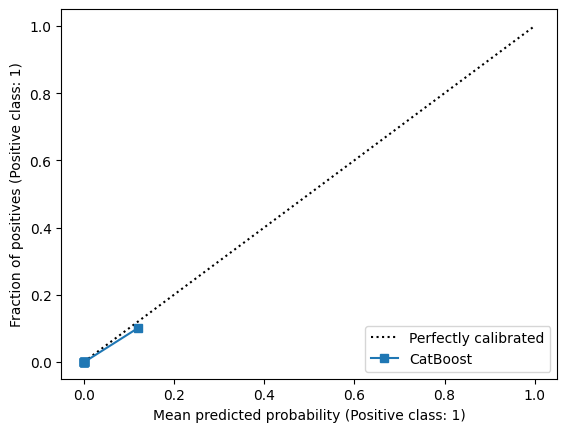

  OK: CalibrationDisplay saved


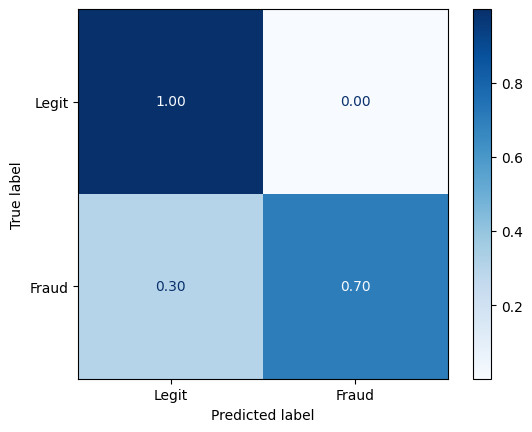

  OK: ConfusionMatrixDisplay saved


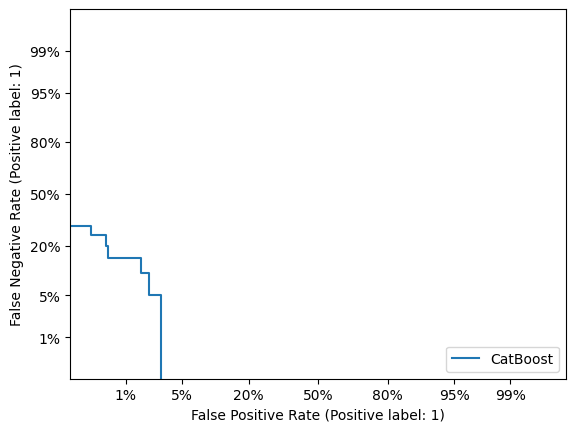

  OK: DetCurveDisplay saved


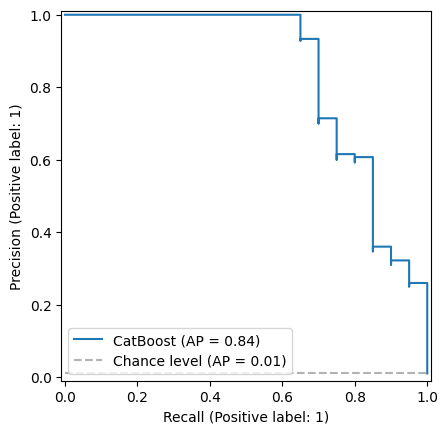

  OK: PrecisionRecallDisplay saved


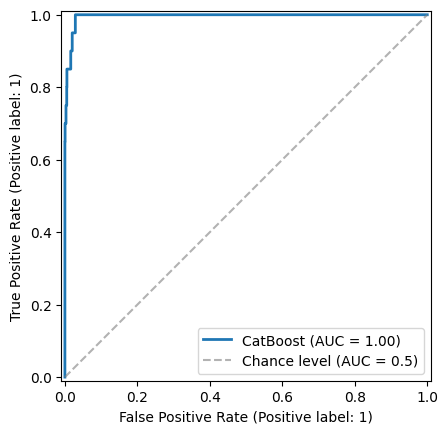

  OK: RocCurveDisplay saved


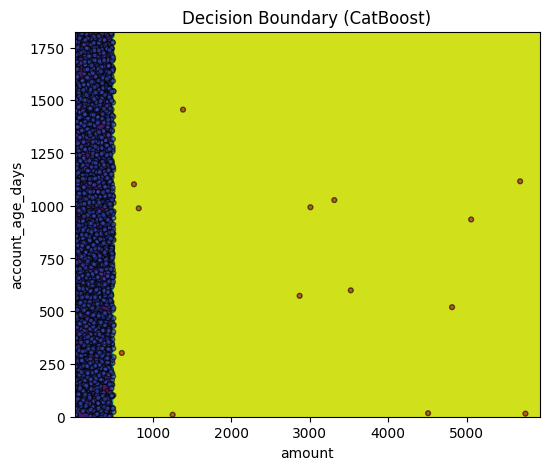

  OK: DecisionBoundaryDisplay saved


/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:721: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


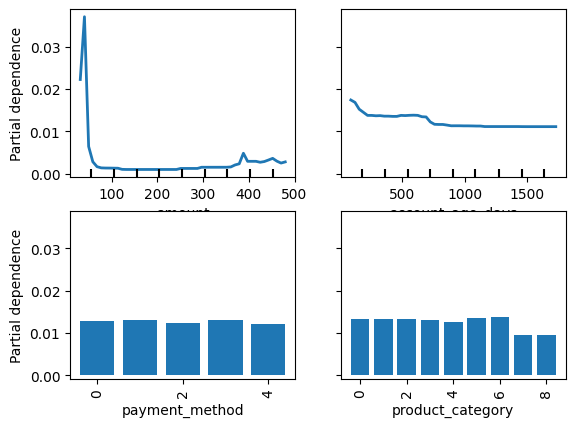

  OK: PartialDependenceDisplay saved
0:	total: 4.49ms	remaining: 4.48s
100:	total: 1.05s	remaining: 9.39s
200:	total: 2.49s	remaining: 9.9s
300:	total: 3.67s	remaining: 8.53s
400:	total: 4.7s	remaining: 7.02s
500:	total: 5.71s	remaining: 5.69s
600:	total: 6.61s	remaining: 4.39s
700:	total: 7.4s	remaining: 3.15s
800:	total: 8.29s	remaining: 2.06s
900:	total: 9.03s	remaining: 992ms
999:	total: 9.95s	remaining: 0us
0:	total: 3.98ms	remaining: 3.98s
100:	total: 810ms	remaining: 7.21s
200:	total: 3.24s	remaining: 12.9s
300:	total: 4.49s	remaining: 10.4s
400:	total: 5.57s	remaining: 8.32s
500:	total: 6.66s	remaining: 6.63s
600:	total: 8.23s	remaining: 5.46s
700:	total: 9.37s	remaining: 4s
800:	total: 10.4s	remaining: 2.58s
900:	total: 11.2s	remaining: 1.23s
999:	total: 12.3s	remaining: 0us
0:	total: 4.7ms	remaining: 4.7s
100:	total: 744ms	remaining: 6.62s
200:	total: 1.96s	remaining: 7.77s
300:	total: 3.3s	remaining: 7.67s
400:	total: 4.47s	remaining: 6.68s
500:	total: 6.08s	remaining: 6.05s

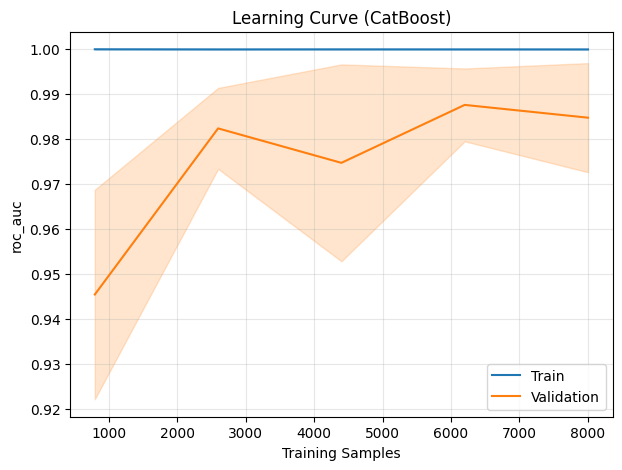

  OK: LearningCurveDisplay saved


KeyboardInterrupt: 

In [33]:
def sklearn_classification_visualizers(viz_config: dict):
    results = {}
    errors = []
    total = 0

    def run_display(name, builder):
        nonlocal total
        total += 1
        try:
            display = builder()
            results[name] = save_display(display, f'{name}.png', show=True)
            print(f'  OK: {name} saved')
        except Exception as exc:
            errors.append((name, str(exc)))
            print(f'  FAILED: {name} failed: {exc}')

    print('')
    print('=== Sklearn Visualization Run ===')

    run_display(
        'CalibrationDisplay',
        lambda: CalibrationDisplay.from_estimator(
            sklearn_estimator, X_test, y_test, **viz_config['calibration']
        ),
    )
    run_display(
        'ConfusionMatrixDisplay',
        lambda: ConfusionMatrixDisplay.from_estimator(
            sklearn_estimator, X_test, y_test, **viz_config['confusion_matrix']
        ),
    )
    run_display(
        'DetCurveDisplay',
        lambda: DetCurveDisplay.from_estimator(
            sklearn_estimator, X_test, y_test, **viz_config['det_curve']
        ),
    )
    run_display(
        'PrecisionRecallDisplay',
        lambda: PrecisionRecallDisplay.from_estimator(
            sklearn_estimator, X_test, y_test, **viz_config['precision_recall']
        ),
    )
    run_display(
        'RocCurveDisplay',
        lambda: RocCurveDisplay.from_estimator(
            sklearn_estimator, X_test, y_test, **viz_config['roc_curve']
        ),
    )

    def decision_boundary_builder():
        fig, ax = plt.subplots(figsize=(6, 5))
        display = DecisionBoundaryDisplay.from_estimator(
            boundary_wrapper,
            X_train_boundary,
            ax=ax,
            **viz_config['decision_boundary'],
        )
        ax.scatter(
            X_test_boundary[boundary_features[0]],
            X_test_boundary[boundary_features[1]],
            c=y_test,
            cmap='coolwarm',
            alpha=0.6,
            s=12,
            edgecolor='k',
        )
        ax.set_title('Decision Boundary (CatBoost)')
        return display

    run_display('DecisionBoundaryDisplay', decision_boundary_builder)
    run_display(
        'PartialDependenceDisplay',
        lambda: PartialDependenceDisplay.from_estimator(
            sklearn_estimator, X_train, **viz_config['partial_dependence']
        ),
    )

    try:
        fig, ax = plt.subplots(figsize=(7, 5))
        plot_catboost_learning_curve(
            X_train,
            y_train,
            train_sizes=viz_config['learning_curve']['train_sizes'],
            cv=viz_config['learning_curve']['cv'],
            scoring=viz_config['learning_curve']['scoring'],
            title='Learning Curve (CatBoost)',
            ax=ax,
            figsize=(7, 5),
            random_state=viz_config['learning_curve']['random_state'],
        )
        results['LearningCurveDisplay'] = save_figure(fig, 'LearningCurveDisplay.png', show=True)
        print('  OK: LearningCurveDisplay saved')
    except Exception as exc:
        errors.append(('LearningCurveDisplay', str(exc)))
        print(f'  FAILED: LearningCurveDisplay failed: {exc}')

    run_display(
        'ValidationCurveDisplay',
        lambda: ValidationCurveDisplay.from_estimator(
            validation_estimator, X_train, y_train, **viz_config['validation_curve']
        ),
    )

    print('')
    print(f'Saved {len(results)} of {total} sklearn visualizations.')
    if errors:
        print('Failures:')
        for name, error in errors:
            print(f'  {name}: {error}')
    return results

viz_config = sklearn_classification_viz_config()
results = sklearn_classification_visualizers(viz_config)


## Scikit-plot Visualization API (Classification)

Scikit-plot provides quick, presentation-ready classification metrics.
This section mirrors the YellowBrick-style config + runner pattern.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
if not hasattr(scipy, "interp"):
    scipy.interp = np.interp
import scikitplot as skplt


y_pred = catboost_model.predict(X_test)
y_probas = catboost_model.predict_proba(X_test)

SCIKITPLOT_PATH = 'models/transaction_fraud_detection/scikitplot_visualizations'
os.makedirs(SCIKITPLOT_PATH, exist_ok=True)

def save_plot(ax, filename: str, show: bool = True) -> str:
    output_path = os.path.join(SCIKITPLOT_PATH, filename)
    if show:
        plt.show()
    ax.get_figure().savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(ax.get_figure())
    return output_path

In [35]:
import inspect

skplt_modules = {
    'metrics': skplt.metrics,
    'estimators': skplt.estimators,
    'cluster': skplt.cluster,
    'decomposition': skplt.decomposition,
}

for name, mod in skplt_modules.items():
    print(f"\n=== {name}.__dir__() ===")
    print(sorted(mod.__dir__()))
    print(f"\n=== help({name}) ===")
    help(mod)

print('\n=== Plot function signatures ===')
for name, mod in skplt_modules.items():
    for fn_name in sorted([n for n in dir(mod) if n.startswith('plot_')]):
        fn = getattr(mod, fn_name)
        try:
            sig = str(inspect.signature(fn))
        except Exception as exc:
            sig = f'<no signature: {exc}>'
        print(f'{name}.{fn_name}{sig}')



=== metrics.__dir__() ===
['LabelEncoder', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', 'absolute_import', 'auc', 'average_precision_score', 'binary_ks_curve', 'calibration_curve', 'confusion_matrix', 'cumulative_gain_curve', 'deprecated', 'division', 'interp', 'itertools', 'label_binarize', 'np', 'plot_calibration_curve', 'plot_confusion_matrix', 'plot_cumulative_gain', 'plot_ks_statistic', 'plot_lift_curve', 'plot_precision_recall', 'plot_precision_recall_curve', 'plot_roc', 'plot_roc_curve', 'plot_silhouette', 'plt', 'precision_recall_curve', 'print_function', 'roc_curve', 'silhouette_samples', 'silhouette_score', 'unicode_literals', 'unique_labels', 'validate_labels']

=== help(metrics) ===
Help on module scikitplot.metrics in scikitplot:

NAME
    scikitplot.metrics

DESCRIPTION
    The :mod:`scikitplot.metrics` module includes plots for machine learning
    evaluation metrics e.g. confusion matri

In [36]:
def scikitplot_classification_kwargs():
    return {
        'plot_confusion_matrix': {
            'normalize': True,
            'cmap': 'Blues',
            'x_tick_rotation': 0,
            'title': 'Confusion Matrix (Normalized)',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_roc': {
            'plot_micro': True,
            'plot_macro': True,
            'cmap': 'nipy_spectral',
            'title': 'ROC Curves',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_roc_curve': {
            'curves': ('micro', 'macro', 'each_class'),
            'cmap': 'nipy_spectral',
            'title': 'ROC Curve (Micro/Macro/Per-Class)',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_precision_recall': {
            'plot_micro': True,
            'cmap': 'nipy_spectral',
            'title': 'Precision-Recall Curve',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_precision_recall_curve': {
            'curves': ('micro', 'each_class'),
            'cmap': 'nipy_spectral',
            'title': 'Precision-Recall (Micro/Per-Class)',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_ks_statistic': {
            'title': 'KS Statistic Plot',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_calibration_curve': {
            'n_bins': 10,
            'title': 'Calibration (Reliability Curves)',
            'cmap': 'nipy_spectral',
            'clf_names': ['CatBoostClassifier'],
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_cumulative_gain': {
            'title': 'Cumulative Gains Curve',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_lift_curve': {
            'title': 'Lift Curve',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_learning_curve': {
            'cv': 5,
            'shuffle': True,
            'random_state': 42,
            'train_sizes': np.linspace(0.1, 1.0, 6),
            'scoring': 'f1',
            'n_jobs': 1,
            'title': 'Learning Curve',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_feature_importances': {
            'title': 'Feature Importances',
            'feature_names': feature_names,
            'max_num_features': 20,
            'order': 'descending',
            'x_tick_rotation': 45,
            'figsize': (8, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_pca_2d_projection': {
            'title': 'PCA 2-D Projection',
            'biplot': False,
            'feature_labels': feature_names,
            'cmap': 'Spectral',
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
        'plot_pca_component_variance': {
            'title': 'PCA Component Explained Variance',
            'target_explained_variance': 0.9,
            'figsize': (7, 5),
            'title_fontsize': 'large',
            'text_fontsize': 'medium',
        },
    }


In [37]:
def scikitplot_classification_visualizers(cfg: dict):
    results = {}
    errors = []

    def run_plot(name, builder, enabled=True, skip_reason=None):
        if not enabled:
            print(f'  SKIP: {name} ({skip_reason})')
            return
        try:
            ax = builder()
            results[name] = save_plot(ax, f'{name}.png', show=True)
            print(f'  OK: {name} saved')
        except Exception as exc:
            errors.append((name, str(exc)))
            print(f'  FAILED: {name} failed: {exc}')

    print('')
    print('=== Scikit-plot Classification Visualization Run ===')

    run_plot(
        'plot_confusion_matrix',
        lambda: skplt.metrics.plot_confusion_matrix(
            y_test, y_pred, **cfg['plot_confusion_matrix']
        ),
    )
    run_plot(
        'plot_roc',
        lambda: skplt.metrics.plot_roc(y_test, y_probas, **cfg['plot_roc']),
    )
    run_plot(
        'plot_roc_curve',
        lambda: skplt.metrics.plot_roc_curve(
            y_test, y_probas, **cfg['plot_roc_curve']
        ),
    )
    run_plot(
        'plot_precision_recall',
        lambda: skplt.metrics.plot_precision_recall(
            y_test, y_probas, **cfg['plot_precision_recall']
        ),
    )
    run_plot(
        'plot_precision_recall_curve',
        lambda: skplt.metrics.plot_precision_recall_curve(
            y_test, y_probas, **cfg['plot_precision_recall_curve']
        ),
    )
    run_plot(
        'plot_ks_statistic',
        lambda: skplt.metrics.plot_ks_statistic(
            y_test, y_probas, **cfg['plot_ks_statistic']
        ),
    )
    run_plot(
        'plot_calibration_curve',
        lambda: skplt.metrics.plot_calibration_curve(
            y_test, [y_probas[:, 1]], **cfg['plot_calibration_curve']
        ),
    )
    run_plot(
        'plot_cumulative_gain',
        lambda: skplt.metrics.plot_cumulative_gain(
            y_test, y_probas, **cfg['plot_cumulative_gain']
        ),
    )
    run_plot(
        'plot_lift_curve',
        lambda: skplt.metrics.plot_lift_curve(
            y_test, y_probas, **cfg['plot_lift_curve']
        ),
    )

    run_plot(
        'plot_learning_curve',
        lambda: plot_catboost_learning_curve(
            X_train,
            y_train,
            train_sizes=cfg['plot_learning_curve']['train_sizes'],
            cv=cfg['plot_learning_curve']['cv'],
            scoring=cfg['plot_learning_curve']['scoring'],
            title=cfg['plot_learning_curve']['title'],
        ),
        )

    def get_feature_importance_estimator(estimator):
        if hasattr(estimator, 'feature_importances_'):
            return estimator
        if hasattr(estimator, 'named_steps'):
            last_est = list(estimator.named_steps.values())[-1]
            if hasattr(last_est, 'feature_importances_'):
                return last_est
        return None

    fi_estimator = get_feature_importance_estimator(catboost_model)
    run_plot(
        'plot_feature_importances',
        lambda: skplt.estimators.plot_feature_importances(
            fi_estimator, **cfg['plot_feature_importances']
        ),
        enabled=fi_estimator is not None,
        skip_reason='estimator lacks feature_importances_',
    )

    from sklearn.decomposition import PCA

    pca_model = PCA(n_components=2, random_state=42)
    pca_model.fit(X_train)

    run_plot(
        'plot_pca_2d_projection',
        lambda: skplt.decomposition.plot_pca_2d_projection(
            pca_model, X_test, y_test, **cfg['plot_pca_2d_projection']
        ),
    )
    run_plot(
        'plot_pca_component_variance',
        lambda: skplt.decomposition.plot_pca_component_variance(
            pca_model, **cfg['plot_pca_component_variance']
        ),
    )


    print('')
    print(f'Saved {len(results)} scikit-plot visualizations.')
    if errors:
        print('Failures:')
        for name, error in errors:
            print(f'  {name}: {error}')
    return results



=== Scikit-plot Classification Visualization Run ===


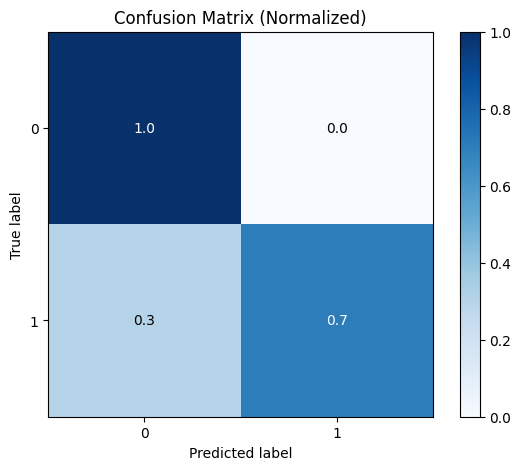

  OK: plot_confusion_matrix saved


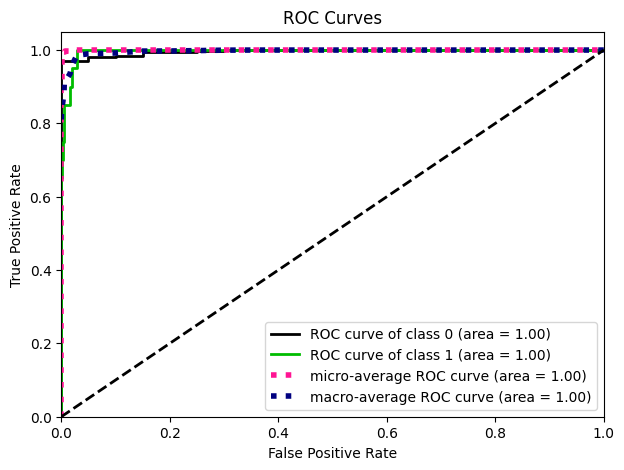

  OK: plot_roc saved


/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


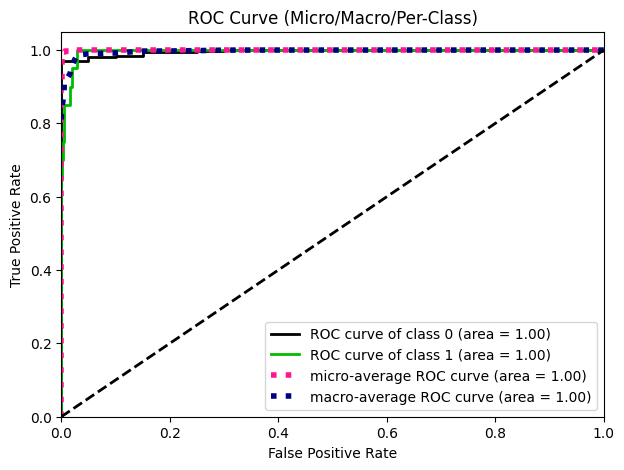

  OK: plot_roc_curve saved


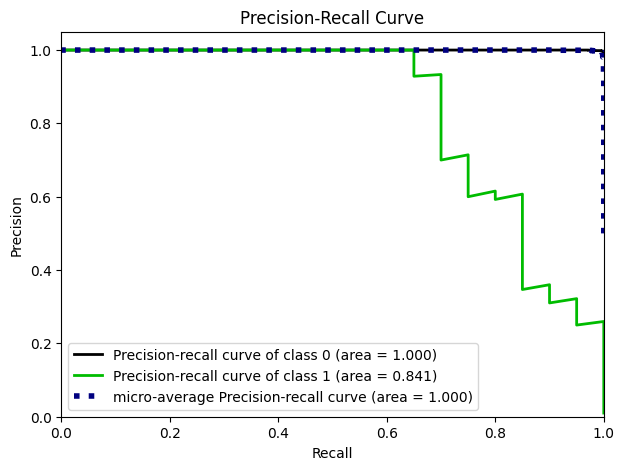

  OK: plot_precision_recall saved


/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


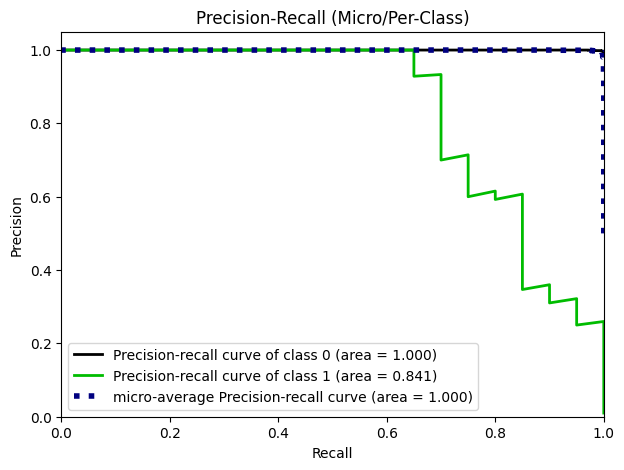

  OK: plot_precision_recall_curve saved


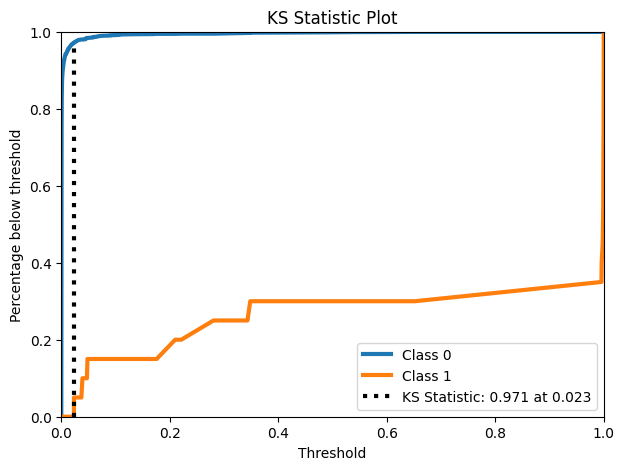

  OK: plot_ks_statistic saved


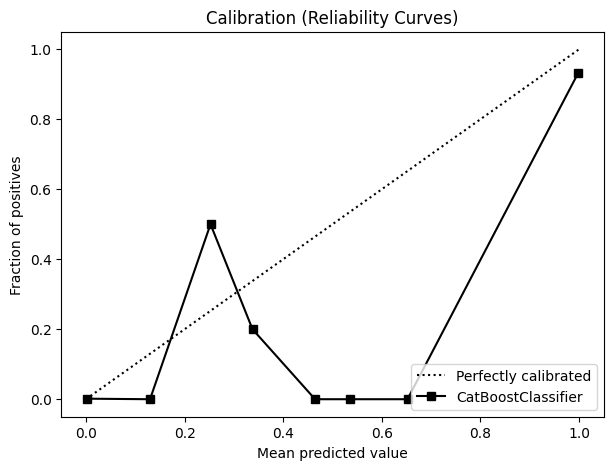

  OK: plot_calibration_curve saved


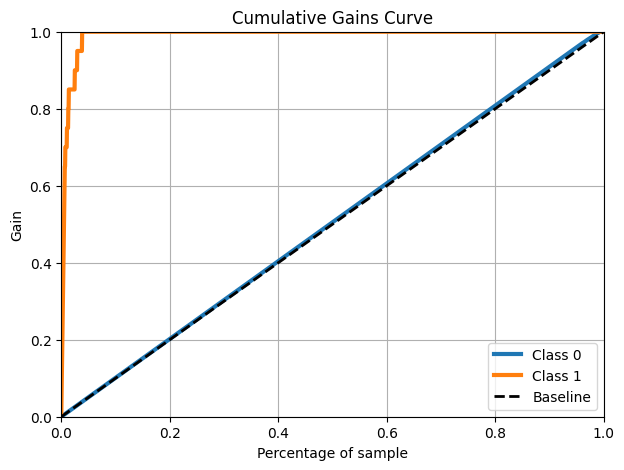

  OK: plot_cumulative_gain saved


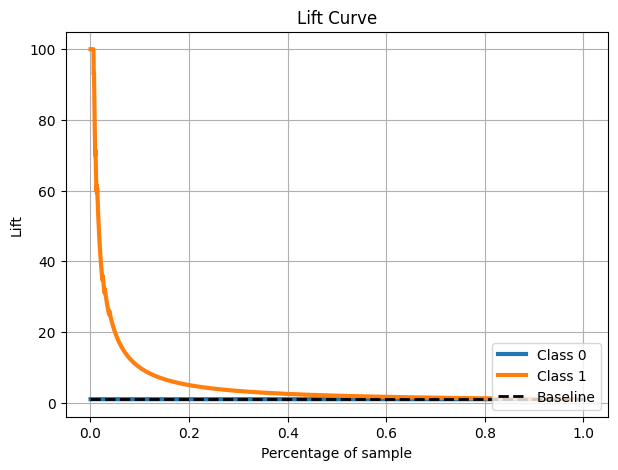

  OK: plot_lift_curve saved
0:	total: 3.29ms	remaining: 3.28s
100:	total: 686ms	remaining: 6.11s
200:	total: 1.59s	remaining: 6.32s
300:	total: 2.39s	remaining: 5.56s
400:	total: 3.1s	remaining: 4.62s
500:	total: 3.83s	remaining: 3.81s
600:	total: 4.49s	remaining: 2.98s
700:	total: 5.31s	remaining: 2.27s
800:	total: 6.2s	remaining: 1.54s
900:	total: 6.97s	remaining: 766ms
999:	total: 7.82s	remaining: 0us
0:	total: 3.6ms	remaining: 3.6s
100:	total: 761ms	remaining: 6.77s
200:	total: 1.91s	remaining: 7.61s
300:	total: 3.45s	remaining: 8.02s
400:	total: 4.54s	remaining: 6.78s
500:	total: 5.43s	remaining: 5.41s
600:	total: 6.44s	remaining: 4.28s
700:	total: 7.49s	remaining: 3.19s
800:	total: 8.28s	remaining: 2.06s
900:	total: 9.4s	remaining: 1.03s
999:	total: 10.2s	remaining: 0us
0:	total: 3.14ms	remaining: 3.14s
100:	total: 775ms	remaining: 6.9s
200:	total: 2.06s	remaining: 8.18s
300:	total: 3.64s	remaining: 8.44s
400:	total: 4.97s	remaining: 7.43s
500:	total: 6s	remaining: 5.98s
600:	tot

KeyboardInterrupt: 

In [38]:
scikitplot_config = scikitplot_classification_kwargs()
scikitplot_results = scikitplot_classification_visualizers(scikitplot_config)